# Building a Database for Crime Reports

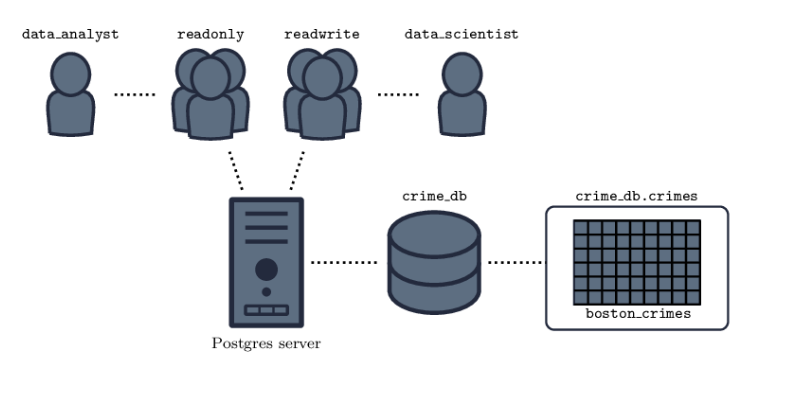

In [32]:
Image(filename='gitimage.PNG')

In [2]:
!pip install psycopg2

# Importing the library

In [7]:
import psycopg2
conn = psycopg2.connect("host=127.0.0.1 user=postgres password=*****")
#set autocommit to true because this is required for creating database
conn.autocommit = True
cur = conn.cursor()
cur.execute("Create DATABASE crime_db;")
conn.close()

# Create a connection to the database

In [20]:
conn = psycopg2.connect(dbname="crime_db", user='postgres', password='*****')
conn.autocommit = True
cur = conn.cursor()
#create the crimes schema
cur.execute("CREATE SCHEMA bcrimes;")

# Reading the csv file 

In [9]:
import csv
with open ('crime.csv') as file:
    reader = csv.reader(file)
    col_headers = next(reader)
    first_row = next(reader)

In [10]:
def get_col_set(csv_file, col_index):
    import csv
    values = set()
    with open(csv_file, 'r') as f:
        next(f)
        reader = csv.reader(f)
        for row in reader:
            values.add(row[col_index])
    return values

for i in range(len(col_headers)):
    values = get_col_set("crime.csv", i)
    print(col_headers[i], len(values), sep='\t')

INCIDENT_NUMBER	282517
OFFENSE_CODE	222
OFFENSE_CODE_GROUP	67
OFFENSE_DESCRIPTION	244
DISTRICT	13
REPORTING_AREA	879
SHOOTING	2
OCCURRED_ON_DATE	232566
YEAR	4
MONTH	12
DAY_OF_WEEK	7
HOUR	24
UCR_PART	5
STREET	4658
Lat	18179
Long	18179


In [11]:
print(col_headers)

['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Lat', 'Long']


In [12]:
descriptions = get_col_set("crime.csv", 2) # description is at index number 2
max_len = 0
for description in descriptions:
    max_len = max(max_len, len(description))
print(max_len)

41


# Creating the Table

In [13]:
print(col_headers)
print(first_row)

['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Lat', 'Long']
['I182070945', '619', 'Larceny', 'LARCENY ALL OTHERS', 'D14', '808', '', '9/2/2018 13:00', '2018', '9', 'Sunday', '13', 'Part One', 'LINCOLN ST', '42.35779134', '-71.13937053']


In [21]:
#create the table.
cur.execute("""
CREATE TABLE Bcrimes.boston_crimes(
incident_number VARCHAR(100),
offense_code INTEGER,
offense_code_group VARCHAR(100),
offense_description VARCHAR(100),
district VARCHAR(100) NULL,
reporting_area VARCHAR(45) NULL,
shooting VARCHAR(45) NULL,
occurred_on_date DATE,
year INTEGER,
month INTEGER,
day_of_the_week VARCHAR(45),
hour INTEGER,
ucr_part VARCHAR(100) NULL,
street VARCHAR(100),
lat decimal NULL,
long decimal NULL);



""")

# Load the Data into the Table

In [22]:
# Load the data from boston.csv into the table boston_crimes that is in the crimes schema.
with open("crime.csv") as f:
    cur.copy_expert("COPY bcrimes.boston_crimes FROM STDIN WITH CSV HEADER;", f)
cur.execute("SELECT * FROM bcrimes.boston_crimes")
# Print the number of rows to ensure that they were loaded.
print(len(cur.fetchall()))

319073


# Revoke public priveledges

In [23]:
cur.execute("REVOKE ALL ON SCHEMA public FROM public;")
cur.execute("REVOKE ALL ON DATABASE crime_db FROM public;")

# Creating the read only group

In [24]:
cur.execute("CREATE GROUP readonly NOLOGIN;")
cur.execute("GRANT CONNECT ON DATABASE crime_db TO readonly;")
cur.execute("GRANT USAGE ON SCHEMA crimes TO readonly;")
cur.execute("GRANT SELECT ON ALL TABLES IN SCHEMA crimes TO readonly;")

DuplicateObject: role "readonly" already exists


# Creating the Read Write group

In [25]:
cur.execute("CREATE GROUP readwrite NOLOGIN;")
cur.execute("GRANT CONNECT ON DATABASE crime_db TO readwrite;")
cur.execute("GRANT USAGE ON SCHEMA crimes TO readwrite;")
cur.execute("GRANT SELECT, INSERT, UPDATE, DELETE ON ALL TABLES IN SCHEMA crimes TO readwrite;")


DuplicateObject: role "readwrite" already exists


# Creating one user for each group

In [27]:
cur.execute("CREATE USER data_analyst WITH PASSWORD 'secret1';")
cur.execute("GRANT readonly TO data_analyst;")

cur.execute("CREATE USER data_scientist WITH PASSWORD 'secret2';")
cur.execute("GRANT readwrite TO data_scientist;")

InterfaceError: cursor already closed

# testing the database setup

In [26]:
# Close the old connection to test with a brand new connection.
conn.close()

conn = psycopg2.connect(dbname="crime_db", user='postgres', password='****')
cur = conn.cursor()
# Check users and groups.
cur.execute("""
    SELECT rolname, rolsuper, rolcreaterole, rolcreatedb, rolcanlogin FROM pg_roles
    WHERE rolname IN ('readonly', 'readwrite', 'data_analyst', 'data_scientist');
""")
for user in cur:
    print(user)
print()
# check privileges
cur.execute("""
    SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee IN ('readonly', 'readwrite');
""")
for user in cur:
    print(user)
conn.close()

('readonly', False, False, False, False)
('readwrite', False, False, False, False)
('data_analyst', False, False, False, True)
('data_scientist', False, False, False, True)

